In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



In [3]:
import matplotlib.pyplot as plt
import seaborn as sn
train = pd.read_json("/kaggle/input/facebook-hateful-meme-dataset/data/train.jsonl",lines=True)
test = pd.read_json("/kaggle/input/facebook-hateful-meme-dataset/data/test.jsonl",lines=True)
val = pd.read_json("/kaggle/input/facebook-hateful-meme-dataset/data/dev.jsonl",lines=True)
train.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [4]:
train.shape, test.shape, val.shape

((8500, 4), (1000, 3), (500, 4))

In [5]:
df = pd.concat([train, val])
df.shape

(9000, 4)

In [6]:
df

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
...,...,...,...,...
495,83675,img/83675.png,0,i'm gonna be like phelps one day
496,37198,img/37198.png,0,when you're so relaxed you can feel yourself g...
497,48670,img/48670.png,0,look at this sandwich maker club i found on wi...
498,9863,img/09863.png,0,diverse group of women


In [7]:
df.groupby(['label']).count()

,id,img,text
label,,,
0,5700,5700,5700
1,3300,3300,3300


In [8]:
import pandas as pd
from bs4 import BeautifulSoup

# Remove HTML syntax and statements from resume text
def remove_html_tags(text):
    soup = BeautifulSoup(text, 'html.parser')
    cleaned_text = soup.get_text()
    return cleaned_text

# Apply remove_html_tags function to 'resume' column
df['text'] = df['text'].apply(remove_html_tags)
df['text'] = df['text'].astype('str')
df['label'] = df['label'].astype('str')
max_len = max(len(text) for text in df['text'])
print("Maximum length:", max_len)

/tmp/ipykernel_28/641380580.py:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


Maximum length: 433


In [9]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 43.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.33.0
    Uninstalling transformers-4.33.0:
      Successfully uninstalled transformers-4.33.0


In [10]:
from sklearn import preprocessing
X = df['text']

In [11]:
def data_creation(X,token):
    input_ids=[]
    attention_masks=[]
    for sent in tqdm(X):
        dbert_inps=token.encode_plus(str(sent),add_special_tokens = True,max_length =max_len,pad_to_max_length = True,return_attention_mask = True,truncation=True)
        input_ids.append(dbert_inps['input_ids'])
        attention_masks.append(dbert_inps['attention_mask'])

    input_ids=np.asarray(input_ids)
    attention_masks=np.array(attention_masks)
    print(len(input_ids),len(attention_masks))
    return input_ids,attention_masks
def extr(model_use):
    OP = []
    for batch in tqdm(range(0,input_ids.shape[0],64)):
        op = model_use(input_ids[batch:min(input_ids.shape[0],batch+64),:])[0][:,0,:]
        for i in op:
            OP.append(i.numpy())
    print(len(OP))
    OP = np.array(OP)
    return OP

# Funnel Net

In [12]:
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, TFFunnelModel

tokenizer = AutoTokenizer.from_pretrained("funnel-transformer/small")
model = TFFunnelModel.from_pretrained("funnel-transformer/small")
model_use = model
token_use = tokenizer
input_ids,attention_masks = data_creation(X,token_use)
OP_funnel = extr(model_use)
OP_funnel.shape

/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer TruncatedNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
All model checkpoint layers were used when initializing TFFunnelModel.

All the layers of TFFunnelModel were initialized from the model checkpoint at funnel-transformer/small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFFunnelModel for predictions without further training.


  0%|          | 0/9000 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


9000 9000


  0%|          | 0/141 [00:00<?, ?it/s]

9000


(9000, 768)

# XLNET

In [13]:
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, TFXLNetModel

tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")
model = TFXLNetModel.from_pretrained("xlnet-base-cased")
model_use = model
token_use = tokenizer
input_ids,attention_masks= data_creation(X,token_use)
OP_XLN = extr(model_use)
OP_XLN.shape

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


  0%|          | 0/9000 [00:00<?, ?it/s]

9000 9000


  0%|          | 0/141 [00:00<?, ?it/s]

9000


(9000, 768)

# BERT

In [14]:
from transformers import BertTokenizer, TFBertModel, TFDistilBertModel,DistilBertTokenizer , RobertaTokenizer, TFRobertaModel
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')
model_use = model
token_use = tokenizer
input_ids,attention_masks = data_creation(X,token_use)
OP_BERT = extr(model_use)
OP_BERT.shape

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

  0%|          | 0/9000 [00:00<?, ?it/s]

9000 9000


  0%|          | 0/141 [00:00<?, ?it/s]

9000


(9000, 768)

# VISION

In [15]:
import numpy as np
import pandas as pd
import os
%matplotlib inline  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from xgboost import plot_tree
from xgboost import plot_importance
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from collections import Counter
import cv2
import os
import glob
import skimage
import numpy as np
import pandas as pd
import seaborn as sn
import preprocessing
from tqdm import tqdm
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from skimage.transform import resize
from collections import Counter
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import  metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # Inception
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import xgboost as xgb
from sklearn.ensemble import *
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import model_selection
from sklearn.metrics import accuracy_score, log_loss
import sklearn
import string
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,confusion_matrix
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import  metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
warnings.filterwarnings("ignore")

In [16]:
w , h= 64,64
final_class = 2 # 1 for meningioma, 2 for glioma, 3 for pituitary tumor
w,h,final_class

(64, 64, 2)

In [18]:
df = df.reset_index()

In [19]:
from tqdm import tqdm
import cv2
X = []
XnormBL = []
y = []
DIR = '/kaggle/input/facebook-hateful-meme-dataset/data/'
for location in tqdm(df.index):
    img = df.loc[location,'img']
    img = cv2.imread(DIR + img) 
    if img is not None:
        img = cv2.resize(img, (w,h), interpolation = cv2.INTER_AREA)
        X.append(img)
        img_normalized = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        img1 = cv2.bilateralFilter(img_normalized, 5, 10, 10)
        XnormBL.append(img1)
        y.append(df.loc[location,'label'])

X = np.array(X)
XnormBL = np.array(XnormBL)
y = np.array(y)
('Original Image',X.shape), ('Normalised and Bilateral filtered images',XnormBL.shape), ('Y True or Ground Truths',y.shape)

100%|██████████| 9000/9000 [03:42<00:00, 40.37it/s]


(('Original Image', (9000, 64, 64, 3)),
 ('Normalised and Bilateral filtered images', (9000, 64, 64, 3)),
 ('Y True or Ground Truths', (9000,)))

In [20]:
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.vgg19 import VGG19 # VGG19
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.xception import Xception # Xception
from tensorflow.keras.applications.mobilenet import MobileNet # MobileNet
from tensorflow.keras.applications.nasnet import NASNetMobile # NASNetMobile
from tensorflow.keras.applications.densenet import DenseNet169 # DenseNet169
from tensorflow.keras.applications.densenet import DenseNet121 # DenseNet121
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2 # MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3 # InceptionV3
from tensorflow.keras.layers import *
def FEX(name):
    input1 = Input(shape=(X.shape[1],X.shape[2],3,))
    FE_sigma_X = name(input_shape=(64,64,3), weights='imagenet', include_top=False)(input1)
    FE_sigma_X_OP1 = Flatten()(FE_sigma_X)
    FE_sigma_X_OP1 = Dense(512)(FE_sigma_X_OP1)
    model_FV = Model(inputs=input1,outputs=FE_sigma_X_OP1)
    return model_FV
def extr(name,X):
    model_FV = FEX(name)
    tf.keras.utils.plot_model(model_FV, show_shapes=True)
    X_OP = model_FV.predict(X)
    dfFE = pd.DataFrame(X_OP)
    print(X_OP.shape,y.shape)
    return X_OP,model_FV

# Resnet

In [22]:
name = ResNet50
FeXr,model_FVr = extr(name, X)
np.save('Fex_merger_org.npy',FeXr)
FeXr.shape,y.shape

282/282 [==============================] - 3s 9ms/step
(9000, 512) (9000,)


((9000, 512), (9000,))

# DenseNet

In [23]:
name = DenseNet121
FeXd,model_FVd = extr(name, X)
FeXd.shape,y.shape

282/282 [==============================] - 7s 14ms/step
(9000, 512) (9000,)


((9000, 512), (9000,))

# ConvexNet

In [24]:
def FEX():
    input1 = Input(shape=(X.shape[1],X.shape[2],3,))
    FE_sigma_X = tf.keras.applications.ConvNeXtBase(input_shape=(64,64,3), weights='imagenet', include_top=False)(input1)
    FE_sigma_X_OP1 = Flatten()(FE_sigma_X)
    FE_sigma_X_OP1 = Dense(512)(FE_sigma_X_OP1)
    model_FV = Model(inputs=input1,outputs=FE_sigma_X_OP1)
    return model_FV
def extr(X):
    model_FV = FEX()
    X_OP = model_FV.predict(X)
    dfFE = pd.DataFrame(X_OP)
    print(X_OP.shape,y.shape)
    return X_OP,model_FV

FeXc,model_FVc = extr( X)

282/282 [==============================] - 28s 74ms/step
(9000, 512) (9000,)


# Modelling

In [25]:
from sklearn.preprocessing import OneHotEncoder
Y = np.array(df['label'])
Y = Y.reshape(Y.shape[0],1)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(Y)
Y = enc.transform(Y).toarray()
Y.shape

(9000, 2)

In [26]:
from tensorflow.keras.layers import LSTM,add
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout,MaxPool1D
from tensorflow.keras.layers import LSTM,add
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten,RNN
import tensorflow as tf
from tensorflow.keras.layers import Input

def create_model(max_len,num_classes,mod):
    inps1 = Input(shape = (768,), dtype='int64')
    inps2 = Input(shape = (768,), dtype='int64')
    inps3 = Input(shape = (768,), dtype='int64')
    inps4 = Input(shape = (512,), dtype='int64')
    inps5 = Input(shape = (512,), dtype='int64')
    inps6 = Input(shape = (512,), dtype='int64')
    dense_1 = Dense(2048,activation='relu'  )(inps1)
    dense_1 = Dense(1024,activation='relu'  )(dense_1)
    dense_1 = Dense(1024,activation='relu'  )(dense_1)
    dense_1 = Dense(512,activation='relu'  )(dense_1)
    
    dense_2 = Dense(2048,activation='relu'  )(inps2)
    dense_2 = Dense(1024,activation='relu'  )(dense_2)
    dense_2 = Dense(1024,activation='relu'  )(dense_2)
    dense_2 = Dense(512,activation='relu'  )(dense_2)
    
    dense_3 = Dense(2048,activation='relu'  )(inps3)
    dense_3 = Dense(1024,activation='relu'  )(dense_3)
    dense_3 = Dense(1024,activation='relu'  )(dense_3)
    dense_3 = Dense(512,activation='relu'  )(dense_3)
    
    dense_4 = Dense(2048,activation='relu'  )(inps4)
    dense_4 = Dense(1024,activation='relu'  )(dense_4)
    dense_4 = Dense(1024,activation='relu'  )(dense_4)
    dense_4 = Dense(512,activation='relu'  )(dense_4)
    
    dense_5 = Dense(2048,activation='relu'  )(inps5)
    dense_5 = Dense(1024,activation='relu'  )(dense_5)
    dense_5 = Dense(1024,activation='relu'  )(dense_5)
    dense_5 = Dense(512,activation='relu'  )(dense_5)
    
    dense_6 = Dense(2048,activation='relu'  )(inps6)
    dense_6 = Dense(1024,activation='relu'  )(dense_6)
    dense_6 = Dense(1024,activation='relu'  )(dense_6)
    dense_6 = Dense(512,activation='relu'  )(dense_6)
    
    concat_1 =tf.keras.layers.Concatenate()([dense_1, dense_4])
    dense_1 = Dense(512,activation='relu' )(concat_1)
    concat_2 =tf.keras.layers.Concatenate()([dense_2, dense_5])
    dense_2 = Dense(512,activation='relu' )(concat_2)
    concat_3 =tf.keras.layers.Concatenate()([dense_3, dense_6])
    dense_3 = Dense(512,activation='relu' )(concat_3)
    concat_4 =tf.keras.layers.Concatenate()([concat_3, concat_2, concat_1])
    dense_1 = Dense(512,activation='relu' )(concat_4)
    dense_1 = Dense(256,activation='relu' )(dense_1)
    dense_1 = Dense(256,activation='relu' )(dense_1)
    drOPout= Dropout(0.5)(dense_1)
    pred = Dense(2, activation='sigmoid')(drOPout)
    model = tf.keras.Model(inputs=[inps1,inps2,inps3, inps4, inps5, inps6], outputs=pred)
    return model
model = create_model(max_len,8,model_use)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 768)]        0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 512)]        0           []                               
                                                                                            

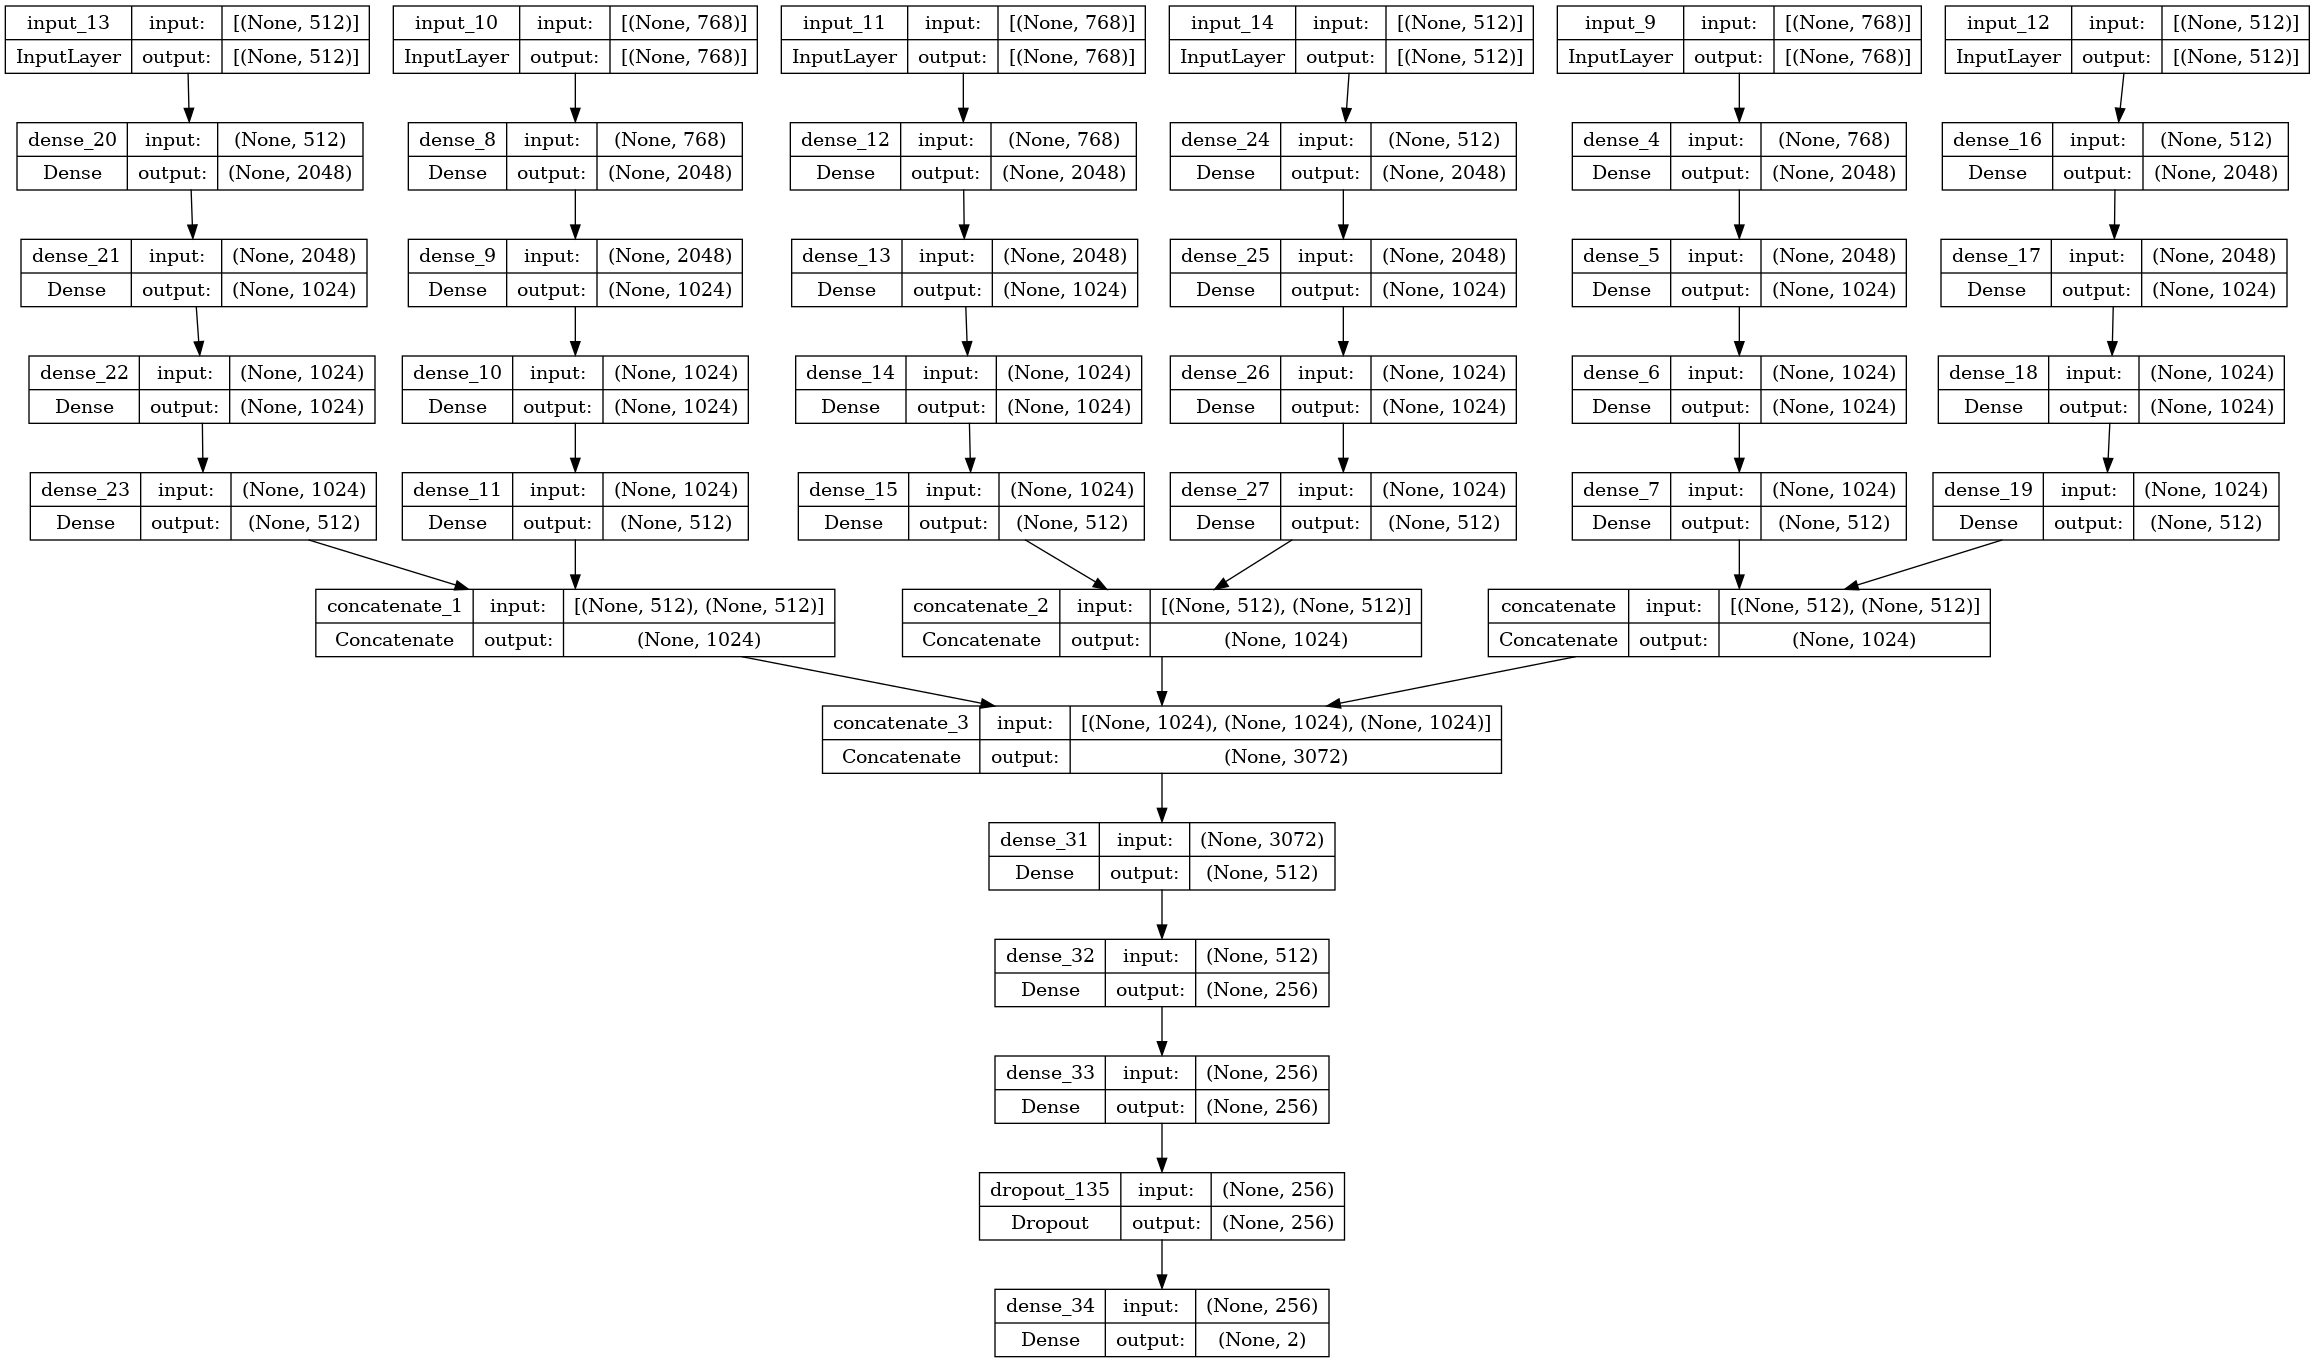

In [27]:
from keras.utils import plot_model
plot_model(model, to_file='model.png',show_shapes=True)

In [28]:
from sklearn.model_selection import train_test_split
X_train_f, X_test_f,X_train_x, X_test_x,X_train_b, X_test_b, X_train_c, X_test_c, X_train_d, X_test_d, X_train_r, X_test_r, y_train, y_test = train_test_split(OP_funnel,OP_XLN, OP_BERT,
                                                                                                FeXc,FeXd, FeXr,
                                                                                                Y, random_state=42, test_size=0.2)
print('Train data    :'+str(X_train_f.shape), X_train_b.shape, str(X_train_x.shape))
print('Train data    :'+str(X_train_c.shape), X_train_d.shape, str(X_train_r.shape))
print('Test data     :'+str(X_test_f.shape), str(X_test_b.shape), str(X_test_x.shape))
print('Test data     :'+str(X_test_c.shape), str(X_test_d.shape), str(X_test_r.shape))
print('Train Output  :'+str(y_train.shape))
print('Test Output   :'+str(y_test.shape))

Train data    :(7200, 768) (7200, 768) (7200, 768)
Train data    :(7200, 512) (7200, 512) (7200, 512)
Test data     :(1800, 768) (1800, 768) (1800, 768)
Test data     :(1800, 512) (1800, 512) (1800, 512)
Train Output  :(7200, 2)
Test Output   :(1800, 2)


In [29]:
METRICS = [
               'accuracy'
        ]  
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./',
                save_weights_only=True,
                monitor='accuracy',
                mode='max',
                save_best_only=True)
model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=METRICS
            )
history = model.fit([OP_funnel, OP_XLN, OP_BERT, FeXc,FeXd, FeXr], Y,
                            epochs=100,
                            verbose=1,
                            shuffle = True,
                            validation_data=([X_test_f,X_test_x,X_test_b, X_test_c,X_test_d, X_test_r],y_test),
                           callbacks=[model_checkpoint_callback])

Epoch 1/100
282/282 [==============================] - 15s 17ms/step - loss: 0.7137 - accuracy: 0.5937 - val_loss: 0.6451 - val_accuracy: 0.6361
Epoch 2/100
282/282 [==============================] - 5s 16ms/step - loss: 0.6586 - accuracy: 0.6297 - val_loss: 0.6164 - val_accuracy: 0.6578
Epoch 3/100
282/282 [==============================] - 4s 16ms/step - loss: 0.6292 - accuracy: 0.6562 - val_loss: 0.6111 - val_accuracy: 0.6472
Epoch 4/100
282/282 [==============================] - 4s 16ms/step - loss: 0.5892 - accuracy: 0.6893 - val_loss: 0.5217 - val_accuracy: 0.7211
Epoch 5/100
282/282 [==============================] - 4s 15ms/step - loss: 0.4907 - accuracy: 0.7697 - val_loss: 0.3359 - val_accuracy: 0.8856
Epoch 6/100
282/282 [==============================] - 4s 16ms/step - loss: 0.3179 - accuracy: 0.8671 - val_loss: 0.1543 - val_accuracy: 0.9478
Epoch 7/100
282/282 [==============================] - 4s 15ms/step - loss: 0.1744 - accuracy: 0.9328 - val_loss: 0.0701 - val_accuracy

In [30]:
from tensorflow.keras.models import model_from_json
model_json = model.to_json()
name ='Model_CB256'
with open(name+".json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(name+".h5")
import pandas as pd
json_file = open('./'+name+'.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('./'+name+'.h5')
print("Loaded model from disk")
hist_df = pd.DataFrame(history.history) 
hist_df.to_csv(name+'.csv',index = False)
hist_df.tail()

Loaded model from disk


,loss,accuracy,val_loss,val_accuracy
95,7.285010e-10,1.0,0.0,1.0
96,4.503460e-10,1.0,0.0,1.0
97,1.006655e-09,1.0,0.0,1.0
98,1.059638e-10,1.0,0.0,1.0
99,9.271833e-11,1.0,0.0,1.0


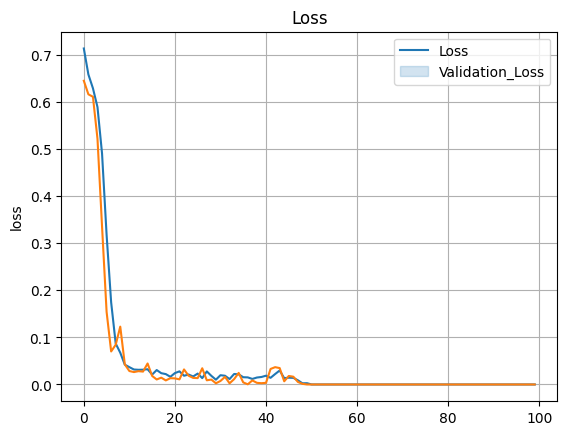

In [31]:
import seaborn as sns
sns.lineplot( x=hist_df.index, y=hist_df['loss'])
sns.lineplot( x=hist_df.index, y=hist_df['val_loss'])
plt.legend(['Loss','Validation_Loss'])
plt.title('Loss')
plt.grid()
plt.show()

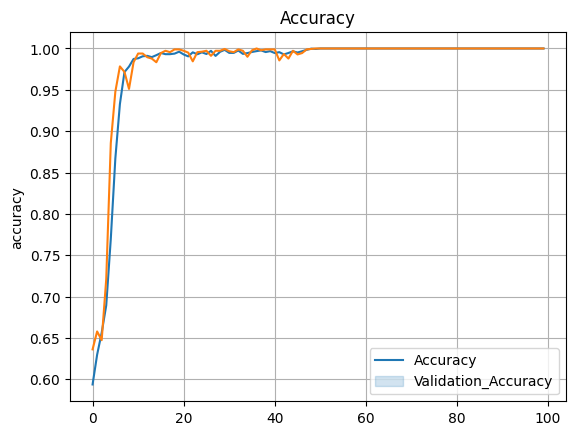

In [32]:
sns.lineplot( x=hist_df.index, y=hist_df['accuracy'])
sns.lineplot( x=hist_df.index, y=hist_df['val_accuracy'])
plt.legend(['Accuracy','Validation_Accuracy'])
plt.title('Accuracy')
plt.grid()
plt.show()

In [34]:
def view_score(score):
    for i in range(len(score)):
        print(loaded_model.metrics_names[i]+" : "+str(score[i]))
METRICS = [
                'accuracy',
                tf.keras.metrics.Recall(),
                tf.keras.metrics.AUC()
    
        ]   
loaded_model.compile(
                optimizer='Adam',
                loss='categorical_crossentropy',
                metrics=METRICS
            )
score = loaded_model.evaluate([X_train_f,X_train_x,X_train_b, X_train_c,X_train_d, X_train_r],y_train, verbose=0)
view_score(score)

loss : 0.0
accuracy : 1.0
recall_1 : 1.0
auc_1 : 1.0


In [35]:
classes = ['Acceptable', 'Hateful']
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import pandas as pd
def pred(X,Y):
    yhat = loaded_model.predict(X)
    yhat = enc.inverse_transform(yhat)
    y_real = enc.inverse_transform(Y)
    return y_real,yhat
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import roc_curve, auc, roc_auc_score,accuracy_score,confusion_matrix
def visualise(y_true,y_pred,name,model_name):
    ConfusionM = confusion_matrix(y_true,y_pred)

    
    #print('ROC AUC score:', 
    #multiclass_roc_auc_score(y_true,y_pred, ))
    print(classification_report(y_true,y_pred  ,target_names = classes,digits=4))
    print()
    fig, ax = plt.subplots(figsize=(16,16)) 
    import seaborn as sns
    sns.heatmap(ConfusionM, annot=True,cmap = 'Greys',xticklabels=classes, yticklabels=classes, fmt='.2f')
    plt.title('Confusion Matrix for '+model_name)
    plt.savefig('CM.jpg')
    plt.show()
from sklearn.metrics import multilabel_confusion_matrix

def classwise(yt,yp,classes,name):
    op = multilabel_confusion_matrix(yt,yp)
    classwise_score = pd.DataFrame()
    j = 0
    for i in op:
        tp,fn,fp,tn = i[0][0],i[0][1],i[1][0],i[1][1]
        acc = (tp+tn)/(tp+tn+fp+fn)
        pre = tp/(tp+fp)
        rec = tp/(tp+fn)
        f1 = 2*rec*pre / (rec +pre)
        sp = tn / (tn +fp)
        Po = (tp + tn) / (tp + tn + fp + fn)
        Pe = ((tp + fn) * (tp + fp) + (fp + tn) * (fn + tn)) / (tp + tn + fp + fn)**2
        # return dictionary
        kp = (Po - Pe) / (1 - Pe)
        classwise_score=classwise_score.append({
            'class' : classes[j],
                'TN':tn,'FP':fp,'FN':fn,'TP':tp,
                'Accuracy':acc,
                'Precision':pre,
                'Recall or Sensitivity':rec,
                'F1 Score':f1,
                'Specificity':sp
            },ignore_index=True)
        j = j + 1
    classwise_score.to_csv(name+'.csv')
    dft = classwise_score.describe()
    dft.to_csv(name+'_stats.csv')
    print(dft)
    return classwise_score
rdf = pd.DataFrame()


225/225 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

  Acceptable     1.0000    1.0000    1.0000      4556
     Hateful     1.0000    1.0000    1.0000      2644

    accuracy                         1.0000      7200
   macro avg     1.0000    1.0000    1.0000      7200
weighted avg     1.0000    1.0000    1.0000      7200




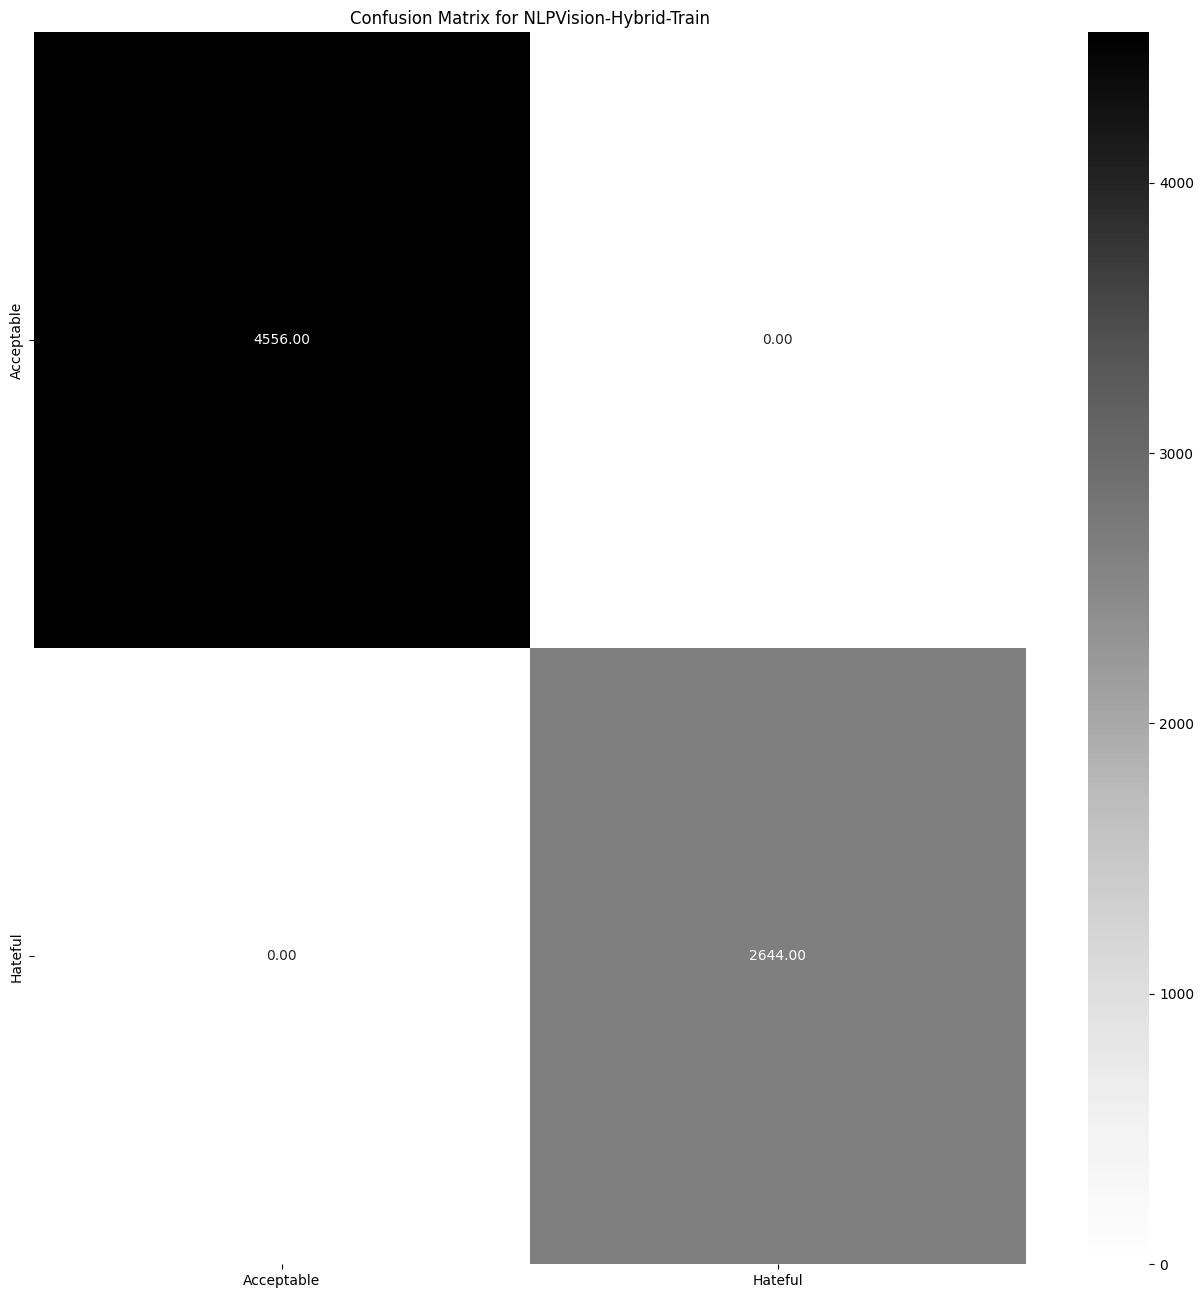

In [36]:
yt,yp = pred([X_train_f,X_train_x,X_train_b, X_train_c,X_train_d, X_train_r],y_train)
visualise(yt,yp,name,'NLPVision-Hybrid-Train')


57/57 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

  Acceptable     1.0000    1.0000    1.0000      1144
     Hateful     1.0000    1.0000    1.0000       656

    accuracy                         1.0000      1800
   macro avg     1.0000    1.0000    1.0000      1800
weighted avg     1.0000    1.0000    1.0000      1800




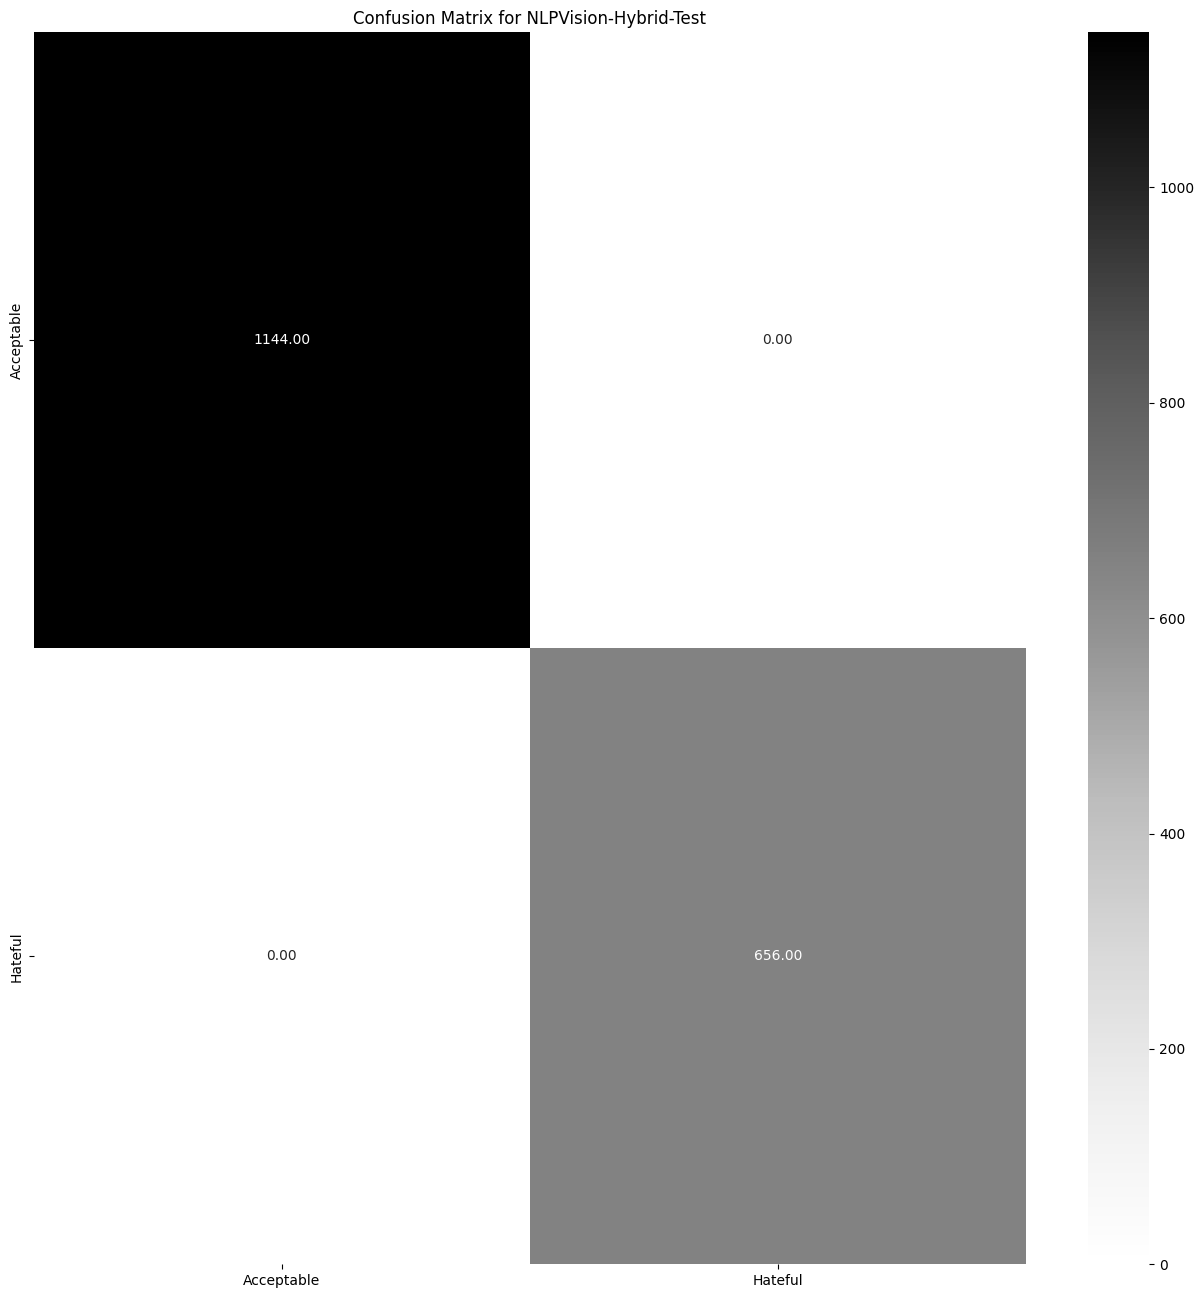

In [37]:
yt,yp = pred([X_test_f,X_test_x,X_test_b, X_test_c,X_test_d, X_test_r],y_test)
visualise(yt,yp,name,'NLPVision-Hybrid-Test')

# Cross validation

In [38]:
def onevsall(y_true,y_pred,mod):
    
    from sklearn.metrics import confusion_matrix
    global rdf
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp+tn)/(tp+tn+fp+fn)
    pre = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*rec*pre / (rec +pre)
    sp = tn / (tn +fp)
    new_data = {
    'Model': mod,
    'TN': tn,
    'FP': fp,
    'FN': fn,
    'TP': tp,
    'Accuracy': acc,
    'Precision': pre,
    'Recall or Sensitivity': rec,
    'F1 Score': f1,
    'Specificity': sp
    }

    # Create a new DataFrame with the new data
    new_df = pd.DataFrame(new_data, index=[0])

    # Concatenate the new DataFrame with the existing one
    rdf = pd.concat([rdf, new_df], ignore_index=True)
        
    return rdf

def roc(clf,x,y):
    import scikitplot as skplt
    import matplotlib.pyplot as plt
    skplt.metrics.plot_roc_curve(clf,x,y)
    plt.savefig('ROC'+model_name+'.jpg')
    plt.show()
    
def visualise(y_true,y_pred,name,model_name):
    ConfusionM = confusion_matrix(y_true,y_pred)

    #print('ROC AUC score:', 
    #multiclass_roc_auc_score(y_true,y_pred, ))
    print(classification_report(y_true,y_pred,   digits=4))
    print()
#     fig, ax = plt.subplots(figsize=(6,4)) 
#     import seaborn as sns
#     sns.heatmap(ConfusionM, annot=True,
#             fmt='g',xticklabels=name, yticklabels=name)
#     plt.title('Confusion Matrix for '+model_name)
#     plt.savefig('CM_'+model_name+'.jpg')
#     plt.show()
    return onevsall(y_true,y_pred,model_name)

In [39]:
from sklearn.model_selection import ShuffleSplit
from tqdm import tqdm
montecarlo_rns = ShuffleSplit(n_splits=10, test_size=0.20, random_state=0)
j = 1
montedf = pd.DataFrame()
for a, b in tqdm(montecarlo_rns.split(X_test_f)):
    X_t = [X_test_f[a],X_test_x[a],X_test_b[a], X_test_c[a],X_test_d[a], X_test_r[a]]
    Y_t = y_test[a]
    
    rdf = pd.DataFrame()
    k= 0
    yt,yp = pred(X_t,Y_t)
    onevsall(yt,yp,'Hybrid Vision Lingusitic Model')
    k = k + 1
    rdf['Monte_Carlo_iteration']='Iteration_'+str(j)
    montedf = pd.concat([montedf,rdf])
    j = j + 1

0it [00:00, ?it/s]

45/45 [==============================] - 0s 3ms/step


1it [00:00,  3.70it/s]

45/45 [==============================] - 0s 3ms/step


2it [00:00,  2.89it/s]

45/45 [==============================] - 0s 5ms/step


3it [00:01,  2.68it/s]

45/45 [==============================] - 0s 3ms/step


4it [00:01,  2.62it/s]

45/45 [==============================] - 0s 3ms/step


5it [00:01,  2.94it/s]

45/45 [==============================] - 0s 3ms/step


6it [00:02,  2.74it/s]

45/45 [==============================] - 0s 3ms/step


7it [00:02,  2.66it/s]

45/45 [==============================] - 0s 3ms/step


8it [00:02,  2.94it/s]

45/45 [==============================] - 0s 3ms/step


9it [00:03,  2.80it/s]

45/45 [==============================] - 0s 3ms/step


10it [00:03,  2.77it/s]


In [40]:
print(montedf.shape)
montedf

(10, 11)


,Model,TN,FP,FN,TP,Accuracy,Precision,Recall or Sensitivity,F1 Score,Specificity,Monte_Carlo_iteration
0,Hybrid Vision Lingusitic Model,904,0,0,536,1.0,1.0,1.0,1.0,1.0,Iteration_1
0,Hybrid Vision Lingusitic Model,923,0,0,517,1.0,1.0,1.0,1.0,1.0,Iteration_2
0,Hybrid Vision Lingusitic Model,910,0,0,530,1.0,1.0,1.0,1.0,1.0,Iteration_3
0,Hybrid Vision Lingusitic Model,920,0,0,520,1.0,1.0,1.0,1.0,1.0,Iteration_4
0,Hybrid Vision Lingusitic Model,925,0,0,515,1.0,1.0,1.0,1.0,1.0,Iteration_5
0,Hybrid Vision Lingusitic Model,906,0,0,534,1.0,1.0,1.0,1.0,1.0,Iteration_6
0,Hybrid Vision Lingusitic Model,916,0,0,524,1.0,1.0,1.0,1.0,1.0,Iteration_7
0,Hybrid Vision Lingusitic Model,906,0,0,534,1.0,1.0,1.0,1.0,1.0,Iteration_8
0,Hybrid Vision Lingusitic Model,918,0,0,522,1.0,1.0,1.0,1.0,1.0,Iteration_9
0,Hybrid Vision Lingusitic Model,917,0,0,523,1.0,1.0,1.0,1.0,1.0,Iteration_10


In [41]:
montedf.to_csv('CV_hybridVisionLiguistic.csv', index = False)

In [ ]:
!zip -r OP.zip ./

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: .virtual_documents/ (stored 0%)
  adding: Model_CB256.h5